In [121]:
import os
import sys

import numpy as np
import pandas as pd

import paths
import pickle
import importlib

sys.path.append("..")
from models import *
from models.utils import *
from models.plotting_utils import *
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from streamfunction_ecco import streamfunction_custom_utils as strf_utils
import matplotlib.pyplot as plt

In [122]:
data_home = paths.LOCAL_DIR
lats = [26, -30, -55, -60]

#### A. COLLECT THE NEEDED DATA

1. Prepare the RAPID streamfunction in the correct format

In [123]:
def format_RAPID(RAPID_path):
    
    PSI_RAPID = xr.open_dataset(os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc"))

    PSI_RAPID['depth'] = - PSI_RAPID['depth']
    PSI_RAPID = (PSI_RAPID
                 .rename({'depth': 'Z'})
                 .rename_vars({'stream_function_mar': 'psi_moc'})
                 .assign_coords(k=('k', np.arange(len(PSI_RAPID.depth.values)))))

    PSI_RAPID['psi_moc'] = (('k', 'time'), PSI_RAPID['psi_moc'].values)
    PSI_RAPID['psi_moc'] = PSI_RAPID['psi_moc'].expand_dims({'latitude': [26.5], 'longitude': [0.0]})
    return PSI_RAPID

In [127]:
# A helper function to add lags to the input dataset
def add_lags_inputs(inputs, num_months_lags):
    inputs = inputs.copy(deep = True)
    
    for field in inputs:
        #for i in range(min(1, num_months_lag + 1), max(1, num_months_lag+1)):
        for i in num_months_lags:
                inputs[f'{field}_lag{i}'] = inputs[field].shift(time = i)

    return inputs

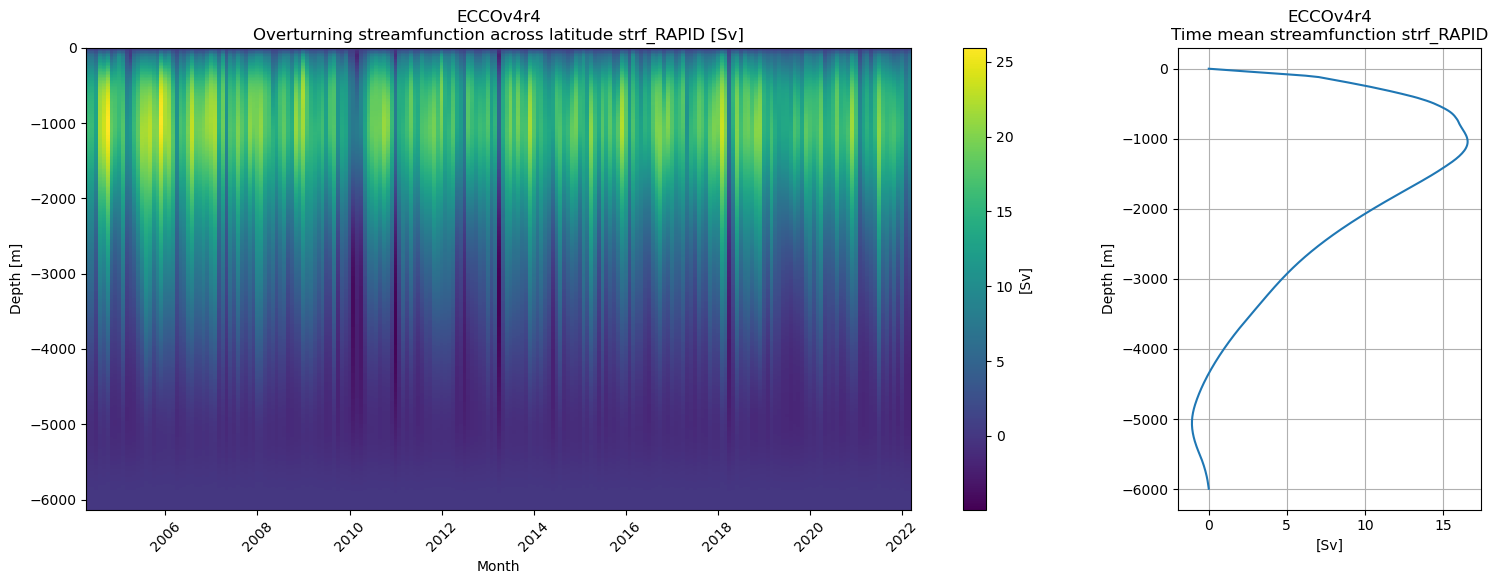

In [171]:
RAPID_path = os.path.join(paths.RAPID_ARRAY, "moc_vertical.nc")

# Resample to monthly mean values
PSI_RAPID = format_RAPID(RAPID_path).resample(time='1ME').mean()

RAPID_inputs = strf_utils.get_PSI_at_max_density_level(
                    PSI_RAPID, moc_param='psi_moc', max=True
                ).drop_vars('Z')

RAPID_inputs = add_lags_inputs(RAPID_inputs, [4,6,12,24,48,72])    

strf_utils.plot_depth_stf_vs_time(stf_ds=PSI_RAPID.squeeze(), label='strf_RAPID', param='psi_moc')

In [172]:
RAPID_inputs

<xarray.Dataset>
Dimensions:        (time: 215, latitude: 1, longitude: 1)
Coordinates:
    k              (latitude, longitude) int32 53
  * latitude       (latitude) float64 26.5
  * longitude      (longitude) float64 0.0
  * time           (time) datetime64[ns] 2004-04-30 2004-05-31 ... 2022-02-28
Data variables:
    psi_moc        (time, latitude, longitude) float64 16.24 15.94 ... 10.85
    psi_moc_lag4   (time, latitude, longitude) float64 nan nan ... 16.38 16.92
    psi_moc_lag6   (time, latitude, longitude) float64 nan nan ... 16.94 15.73
    psi_moc_lag12  (time, latitude, longitude) float64 nan nan ... 9.675 12.81
    psi_moc_lag24  (time, latitude, longitude) float64 nan nan ... 16.39 16.68
    psi_moc_lag48  (time, latitude, longitude) float64 nan nan ... 23.5 20.18
    psi_moc_lag72  (time, latitude, longitude) float64 nan nan ... 12.53 17.24
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

2. Get the Input Surface variables at 30S for the atlantic basin

In [173]:
lat = lats[1]
lat_str = strf_utils.format_lat_lon(lat)

lon_min = -50
lon_max = 17

inputs = xr.open_dataset(f"{data_home}/ecco_data_minimal/{lat_str}.nc").isel(latitude=slice(1,2))
inputs = inputs.sel(longitude=slice(lon_min, lon_max))
inputs

<xarray.Dataset>
Dimensions:    (time: 312, latitude: 1, longitude: 134)
Coordinates:
  * latitude   (latitude) float32 -29.75
  * longitude  (longitude) float32 -49.75 -49.25 -48.75 ... 15.75 16.25 16.75
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables:
    SSH        (time, latitude, longitude) float32 ...
    ZWS        (time, latitude, longitude) float32 ...
    OBP        (time, latitude, longitude) float32 ...
    SSS        (time, latitude, longitude) float32 ...
    SST        (time, latitude, longitude) float32 ...

3. Retrieve the 30S depth streamfunctions for the upper and lower cell

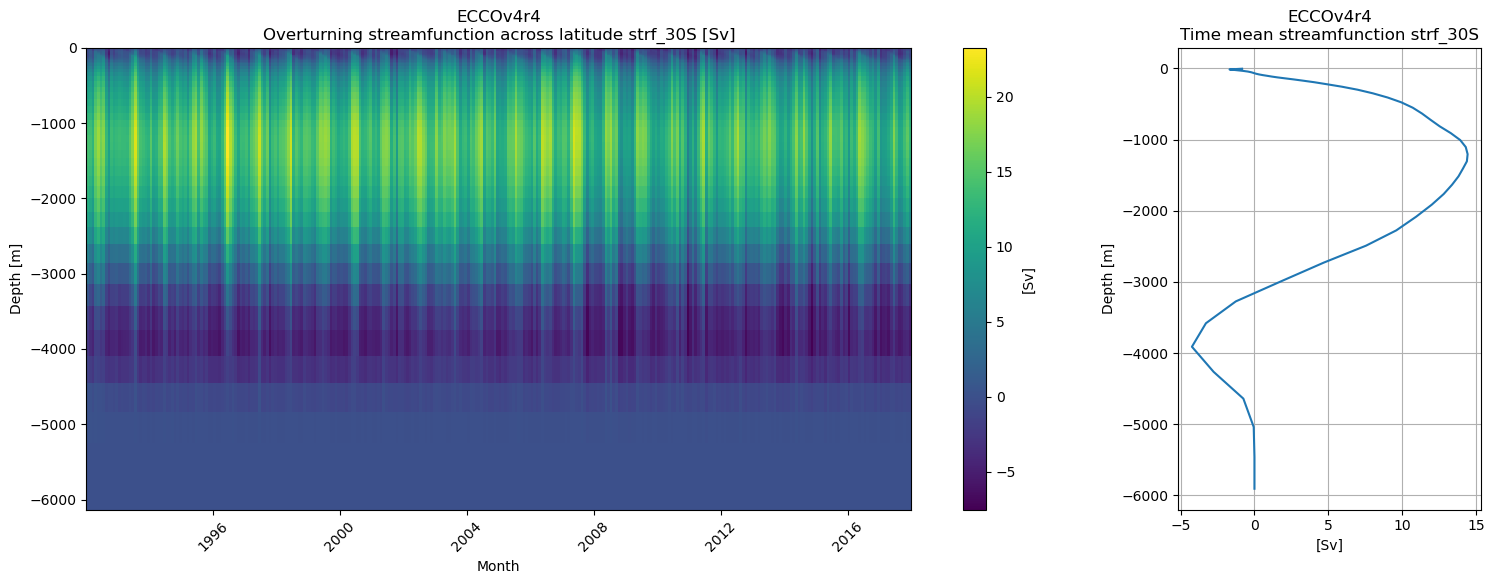

In [174]:
extra_str = 'atlantic_sf'
strf_fp = f"{data_home}/ecco_data_minimal/{lat_str}_{extra_str}_depth.pickle"
depth_fp = f"{data_home}/ecco_data_minimal/depth_range.pickle"
ECCO_GRID = xr.open_dataset(paths.geom_fp)

with open(strf_fp, 'rb') as f:
    strf = pickle.load(f).astype(np.float64)[::-1] #Load the streamfunction and invert the depth values

strf = np.expand_dims(strf[:, 1, :], 1) # grabbing just 30S
strf = np.transpose(strf, (2,0,1))
    
strf = xr.Dataset(
        data_vars = {'moc' : (["time", "k", "latitude"], strf)}, 
        coords = {'time' : inputs.time,  'k': np.arange(50), 'latitude' : np.atleast_1d(-60)}
        )

strf = strf.assign_coords(Z=('k', ECCO_GRID.coords['Z'].data))

outputs_upper_cell = strf_utils.get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=True)
outputs_bottom_cell = strf_utils.get_PSI_at_max_density_level(strf.squeeze(), moc_param='moc', max=False)

strf_utils.plot_depth_stf_vs_time(stf_ds=strf.squeeze(), label='strf_30S', param='moc')

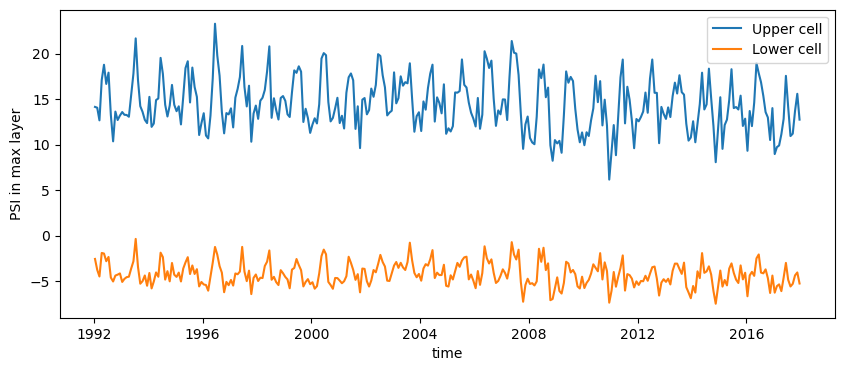

In [175]:
# Plot both streamfunctions for a sanity check

plt.figure(figsize = (10, 4))
plt.plot(outputs_upper_cell["time"].squeeze(), outputs_upper_cell["moc"].squeeze(), label='Upper cell')   
plt.plot(outputs_bottom_cell["time"].squeeze(), outputs_bottom_cell["moc"].squeeze(), label='Lower cell') 
plt.xlabel('time')
plt.ylabel('PSI in max layer')
plt.legend()

#### B. Align the data inputs

In [176]:
# Decide which of the streamfunctions at 30S to predict
outputs = outputs_upper_cell

In [177]:
time_lag = '_lag6'
psi_moc_variable = f"psi_moc{time_lag}"
RAPID_inputs = RAPID_inputs[[psi_moc_variable]]

In [178]:
RAPID_inputs

<xarray.Dataset>
Dimensions:       (time: 215, latitude: 1, longitude: 1)
Coordinates:
    k             (latitude, longitude) int32 53
  * latitude      (latitude) float64 26.5
  * longitude     (longitude) float64 0.0
  * time          (time) datetime64[ns] 2004-04-30 2004-05-31 ... 2022-02-28
Data variables:
    psi_moc_lag6  (time, latitude, longitude) float64 nan nan ... 16.94 15.73
Attributes:
    Title:                         RAPID streamfunction
    Institution:                   National Oceanography Centre,UK
    Website:                       http://www.rapid.ac.uk/rapidmoc
    Acknowledgement:               The RAPID 26N AMOC monitoring project is f...
    Created_by:                    Ben Moat
    Creation_date:                 08-Sep-2023
    Principle_investigator:        Ben Moat
    Principle_investigator_email:  ben.moat@noc.ac.uk
    DOI:                           doi: 10.5285/04c79ece-3186-349a-e063-6c86a...

In [179]:
# RAPID has the latest start date and the ECCO data has the earliest end date (combine)
date_range = (RAPID_inputs.dropna(dim='time', how='any').time.values[0], inputs.time.values[-1]) 
date_range = tuple([str(d).split('T')[0] for d in date_range]) # extracting just the date, w/o time
print('Date range to align to:', date_range)

# Align the surface variable inputs with RAPID, then align the in- and outputs
inputs, RAPID_inputs = align_inputs_outputs(inputs, RAPID_inputs, date_range = date_range, ecco=False)
inputs, outputs = align_inputs_outputs(inputs, outputs, date_range = date_range, ecco=False)

Date range to align to: ('2004-10-31', '2017-12-16')


In [180]:
# Apply standardization to both RAPID and surface data (can't be done together as the longitude dimension still differs in both)
pp_data_RAPID = apply_preprocessing(RAPID_inputs,
                                    mode="inputs",
                                    remove_season=False,
                                    remove_trend=False,
                                    standardize=True,
                                    lowpass=False)

pp_data_surface = apply_preprocessing(inputs,
                              mode="inputs",
                              remove_season=False,
                              remove_trend=False,
                              standardize=True,
                              lowpass=False)

# reshape as desired and convert to a numpy array
pp_data_RAPID_np = reshape_inputs(pp_data_RAPID, keep_coords=["time"], data_vars=[psi_moc_variable])
pp_data_SURFACE_np = reshape_inputs(pp_data_surface, keep_coords=["time"], data_vars=["ZWS"])

# Concatenate the different information layers together
pp_data_np = np.concatenate((pp_data_RAPID_np, pp_data_SURFACE_np), axis=-1)

axes: ['time', 'feature']
variables: ['psi_moc_lag6']
shape: (158, 1)
axes: ['time', 'feature']
variables: ['ZWS']
shape: (158, 1)


In [189]:
# MOC strength preprocessing
strength = apply_preprocessing(outputs,
                               mode="outputs",
                               remove_season=False,
                               remove_trend=False,
                               standardize=False,
                               lowpass=False)
strength_np = strength.moc.squeeze().values

X = pp_data_np
y = strength_np[-X.shape[0]:]

print()
print('Inputs shape:', X.shape)
print('Outputs shape:', y.shape)


Inputs shape: (158, 2)
Outputs shape: (158,)


#### C. Setup the Linear Regressor

In [190]:
class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.1, L1_wt=0.1):
        self.alpha = alpha
        self.L1_wt = L1_wt
        self.model = None

    def fit(self, X, y):
        self.model = sm.OLS(y, X).fit_regularized(alpha=self.alpha, L1_wt=self.L1_wt)
        return self

    def predict(self, X):
        return self.model.predict(X)
    
# add bias term
X = sm.add_constant(X)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, stratify=None, random_state=123456)

device = "cuda" if t.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [195]:
# MISCELLANEOUS
verbose = True
mape_thresh = 0.5
cross_val_folds = 4
param_grid_levels = 2

# hyperparameters to optimise
param_grid = {
    "alpha": np.logspace(-4, 4, 10),
    "L1_wt": np.linspace(0, 1, 10)
}

# grid search - 10-fold cross-validation
grid_search = GridSearchCV(SMWrapper(), param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# report best result
print(f"Best MSE (cross-validation): {round(-grid_search.best_score_, 3)}")

#  calculate test performance and optionally report
y_pred = grid_search.best_estimator_.predict(X_test)
metric_dict = {}
    
metric_dict['R^2'] = round(r2_score(y_test, y_pred), 3)
metric_dict['MSE'] = round(mean_squared_error(y_test, y_pred), 3)
metric_dict['RMSE'] = round(root_mean_squared_error(y_test, y_pred), 3)
metric_dict['MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
metric_dict['MAPE'] = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 3)

#  calculating custom MAPE to ignore the smallest observed MOC values
mape, num_discard = custom_MAPE(y_test, y_pred, threshold = mape_thresh, return_num_discarded = True)
pct_kept = round((len(y_test) - num_discard) / len(y_test) * 100, 3)
metric_dict['MAPE_thresh'] = f'{round(mape * 100, 3)} (thresh={mape_thresh}, {pct_kept}% kept)'

if verbose:
    metrics_series = pd.Series(metric_dict)
    metrics_df = metrics_series.to_frame(name='Value')

Best MSE (cross-validation): 2.408


RESULTS WITH RAPID

,Value
R^2,0.736
MSE,1.806
RMSE,1.344
MAE,1.092
MAPE,8.825
MAPE_thresh,"8.825 (thresh=0.5, 100.0% kept)"


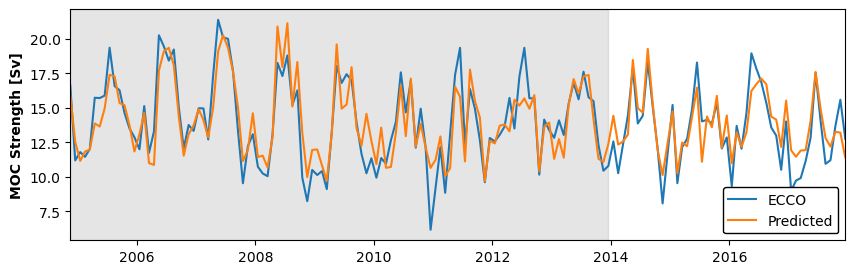

In [196]:
# BEST RESULTS WITHOUT RAPID
# Extracting all predictions in time order
train_set_pred = grid_search.best_estimator_.predict(X_train)
test_set_pred = grid_search.best_estimator_.predict(X_test)
all_preds = np.concatenate([train_set_pred, test_set_pred])

time = outputs.time.values

display(metrics_df)

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

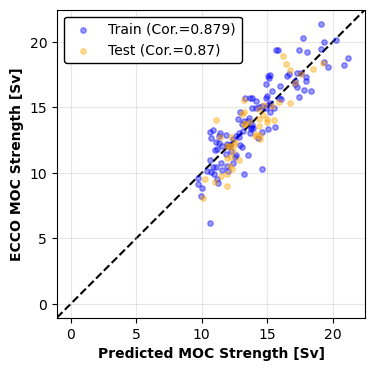

In [197]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
plt.show()

RESULTS WITHOUT RAPID

,Value
R^2,0.729
MSE,1.854
RMSE,1.362
MAE,1.091
MAPE,8.789
MAPE_thresh,"8.789 (thresh=0.5, 100.0% kept)"


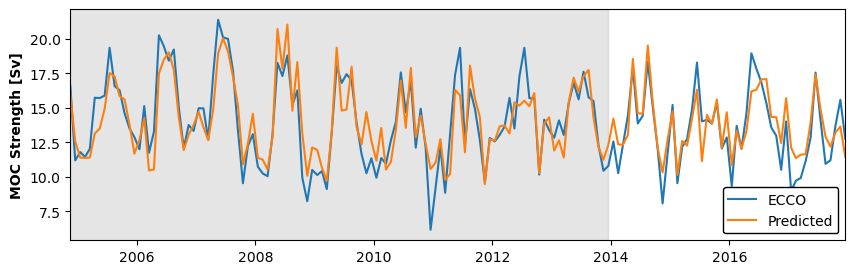

In [187]:
# BEST RESULTS WITHOUT RAPID
# Extracting all predictions in time order
train_set_pred = grid_search.best_estimator_.predict(X_train)
test_set_pred = grid_search.best_estimator_.predict(X_test)
all_preds = np.concatenate([train_set_pred, test_set_pred])

time = outputs.time.values

display(metrics_df)

fig, ax = timeseries_comparison(all_preds, y, time, len(X_train))
plt.show()

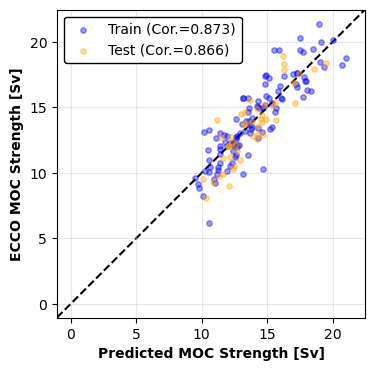

In [188]:
# Alternate view: looking at a scatterplot of predicted vs. actual
fig, ax = pred_vs_actual(train_set_pred, test_set_pred, y_train, y_test)
plt.show()